# Model Development of Loan Predictor

## 1. Introduction

#### **Performance Evaluation**

Let's see below confusion matrix of our prediction:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: left;">
      <th>Actual/Prediction</th>
      <th>Good Loan [0]</th>
      <th>Bad Loan [1]</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Good loan [0]</th>
      <td>TN</td>
      <td>FP</td>
    </tr>
    <tr>
      <th>Bad Loan [1]</th>
      <td>FN</td>
      <td>TP</td>
    </tr>
    </tbody>

So, what metric shall we use for our model? Consider this:

- We want model to be able to detect most of (if not all) possibly defaulted loan as much. For example, if there would be 10 loan to be defaulted, our model would be reliable  if all of those loan is tagged as `Bad Loan`. The metric is **sensitivity** (or *True Positive Rate*): the ratio of positive instances that are correctly detected by the model,
$$sensitivity/TPR=\frac{TP}{FN + TP}$$
         
- In an extreme case, **TPR** can be inflated by a model that tag most of the loan as `Bad Loan`, resulting in a huge number of *False Positive* prediction: most of the `Good Loan` tagged as `Bad Loan`. Therefore, another metric to watch is **FPR** (or *False Positive Rate*): the ratio of negative instance that are incorrectly tagged as positive instance,
$$FPR=\frac{FP}{TN + FP}$$
- TPR is the ability of the model to detect potential loss, which should be avoided. On the other side, FPR is the consequence of its high sensitivity to positive instance, in our cases, we would miss potential profit. We want to optimize trade-off between both metrics. They are commonly considered in **Receiver Operating Characteristic** (ROC): Comparation of *TPR* and *FPR*.

## 1. Dataset Preparation

#### **The Dataset**

We already prepared the similar dataset for exclusively for training and testing:

- Dataset for training: Loan Dataset of 2010 - 2015
- Dataset for testing: Loan Dataset of 2016 - 2017

In [16]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)

train_set = pd.read_csv('dataset\lc_2010-2015.csv', dtype={'desc': 'str', 'verification_status_joint': 'str'})
test_set = pd.read_csv('dataset\lc_2016-2017.csv', dtype={'desc': 'str', 'verification_status_joint': 'str'})

#### **Preparing the Dataset**

In this first part of dataset preparation, we will create a pipeline to transform the dataset which consists of:

- Filtering the dataset: 1) To consider only `INDIVIDUAL` loan; 2) To exclude the on-going loan
- Replacing missing values, as explained in previous section.

I already developed classes for each of the activity: 1) `LoanDataLabelPredictor` for filtering; 2) `LoanDataMissingHandler` to handle missing data. The output of the pipeline is splitted predictor-label set.

In [17]:
from sklearn.pipeline import Pipeline
from modules.data_preprocess import LoanDataPreprocess, LoanDataMissingHandler, LoanDataLabelPredictor 
from sklearn import set_config

dataset_preprocess = Pipeline([
    ('preprocess', LoanDataPreprocess()),
    ('extract_label_predictor', LoanDataLabelPredictor(exclude=['loan_amnt', 'term', 'earliest_cr_line'])),
    ('missing_handler', LoanDataMissingHandler())
    ])

set_config(display='diagram')
dataset_preprocess

Pipeline(steps=[('preprocess', LoanDataPreprocess()),
                ('extract_label_predictor',
                 LoanDataLabelPredictor(exclude=['loan_amnt', 'term',
                                                 'earliest_cr_line'])),
                ('missing_handler', LoanDataMissingHandler())])

In [18]:
from modules.data_exploration import DataExploration

X_train, y_train = dataset_preprocess.fit_transform(train_set)
DataExploration(X_train).show_nans_or_zeroes('nans')

,Nans Count,Nans Percentage (%),Data Types
emp_length,9132,4.34,category
home_ownership,0,0.00,category
annual_inc,0,0.00,float64
verification_status,0,0.00,category
dti,0,0.00,float64
delinq_2yrs,0,0.00,float64
inq_last_6mths,0,0.00,float64
mths_since_last_delinq,0,0.00,float64
mths_since_last_record,0,0.00,float64
open_acc,0,0.00,float64


In [19]:
X_test, y_test = dataset_preprocess.transform(test_set)

Based on previous confusion matrix, we will map the label as follows:

In [20]:
def map_array(x):
    if x == 'Good Loan':
        return 0
    return 1

y_train = np.vectorize(map_array)(y_train)
y_test = np.vectorize(map_array)(y_test)

## 2. Features Preparation

#### **Categorical Features**

In [21]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#### **Numerical Features**

For our base model, let's first just consider scaling the features. This is commonly a standard practice and may turns out to give a proper result for several estimator. However, scaling is not necessary for `logistic regression` and tree-based method.

For dataset which has outliers, scikit-learn provides scaling that robust to this condition.

In [22]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()

#### **Combining Feature Preprocess**

In [23]:
from sklearn.compose import ColumnTransformer

categorical_cols = X_train.select_dtypes(include='category').columns.values
numerical_cols = X_train.select_dtypes(exclude='category').columns.values
ct = ColumnTransformer([
    ('categorical', one_hot, categorical_cols),
    ('numerical', robust_scaler, numerical_cols)
    ]).set_output(transform='pandas')
ct.fit(X_train)
X_train_transfd = ct.transform(X_train)
X_test_transfd = ct.transform(X_test)

## 3. Baseline Models

Now we are going to identify several potentially baseline model for our classification task!
For each potential model, we are going to observe how the model performs by comparing the model performance, focusing on `AUC` score of `Bad Loan` class.

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
# classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# scoring
from sklearn.metrics import roc_auc_score, make_scorer

#classifier
log_clf  =  LogisticRegression(max_iter=3000) # linear
rf_clf  = RandomForestClassifier()
xgb_clf = XGBClassifier(
    max_depth=4, alpha=10, learning_rate=0.5, n_estimators=100,
    )
# initialize an empty list to store the scores
# models = [log_clf, rf_clf, xgb_clf]
models = [xgb_clf]
scoring_method = make_scorer(roc_auc_score, needs_proba=True) # returns callable in form of scorer(estimator, X, y)
# iterate over the models
def cross_val_evaluation(models:list, X, y, scoring_method:callable):
    for model in models:
        model_scores = cross_val_score(
            model, X, y,
            scoring = scoring_method, #scorer(estimator, X, y)
            cv = StratifiedShuffleSplit(n_splits=10)
            )
        # calculate the mean and standard deviation of the scores
        # this is model-specific
        mean_score = np.mean(model_scores)
        std_dev_score = np.std(model_scores)
        # print the mean and standard deviation of the scores
        print(f'{model.__class__.__name__}: Mean score = {mean_score:.2f}, Standard deviation = {std_dev_score:.2f}')

# cross_val_evaluation(models, X_train_transfd, y_train, scoring_method)

In above code:

1. We use cross-validation to estimate test score.
2. We know that, from previous chapter, our dataset has unique proportion of `Good Loan` and `Bad Loan`. Using `StratifiedShuffleSplit`, proportion of `Good Loan` and `Bad Loan` is maintained in every split.
3. We use `roc_auc_score` as the cross-val score. The reason will be explained shortly.

In [25]:
# # plotting
# from sklearn.metrics import RocCurveDisplay
# from sklearn.model_selection import LearningCurveDisplay
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# # models = [log_clf, rf_clf, xgb_clf]
# models = [log_clf]
# for model in models:
#     model.fit(X_train_transfd, y_train)
#     RocCurveDisplay.from_estimator(
#         model, X_test_transfd, y_test,
#         ax=ax[0]
#         )
# for model in models:
#     LearningCurveDisplay.from_estimator(
#         model, X_train_transfd, y_train,
#         ax=ax[1], scoring=make_scorer(roc_auc_score, needs_proba=True),
#         cv=StratifiedShuffleSplit(n_splits=5), 
#         )
# ax[0].set_title('ROC Curve')
# ax[1].set_title('Learning Curve')

Left-hand plot shows *ROC* curve and *AUC* value for each model. The *AUC* is the calculated *Area Under the (ROC) Curve*. It can be seen that, model with higher AUC has steeper curve: the *TPR* is increasing faster at lower *FPR*. In other words, models with higher AUC can obtain higher *TPR* at lower cost.

*ROC* curves shows tradeoff between TPR and FPR along every possible categorizing *treshold* of probability that such observations is part of `Bad Loan` class:

$$\hat{f} < t\;then\;Good\;Loan$$
$$\hat{f}\geq t\;then\;Bad\;Loan$$

where $\hat{f}$ is the *decision function* and $t$ is the *treshold*. This explain the reason why the rightmost side of ROC has $TPR=1$ and $FPR=1$: all of the observations is labeled as *Bad Loan* by setting up the treshold value to the lowest possible *decision function* that obtained from the model.

So our strategy of model selection and optimization is clear: look for model with the best AUC, then we adjust the treshold so that, based on our dataset, maximize the profit (simultaneously minimize the potential loss).

Right-hand plot shows cross-validated learning curve for three of the models. Although we use training set, cross-validation can be used to estimate test result. The error band explains the *standard deviation* of score. We will use *GradientBoosting* since it shows promising performance. 

In [26]:
# df to plot
def plot_importance(fitted_model):
    feature_importances = fitted_model.feature_importances_.reshape(-1, 1)
    feature_names = fitted_model.feature_names_in_.reshape(-1, 1)
    importance_df = pd.DataFrame(
        np.c_[feature_names, feature_importances], 
        columns=['feature_name', 'importance'])
    importance_df = importance_df.assign(
        feature_name=importance_df.feature_name.str.split('__', n=1, expand=True).loc[:, 1],
        importance=importance_df.importance.astype('float64')
        ).sort_values('importance', ascending=False)
    # plot
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x='importance', y='feature_name', data=importance_df.iloc[:20, :], ax=ax, color=sns.color_palette()[0])
    for y_, x_ in enumerate(importance_df.iloc[:20, :].importance.values):
        ax.text(
            x=(x_ + 0.001), 
            y=y_, s=f'{x_:,.3f}',
            verticalalignment='center'
            )
    ax.set_title(f'Feature Importance, {fitted_model.__class__.__name__}')

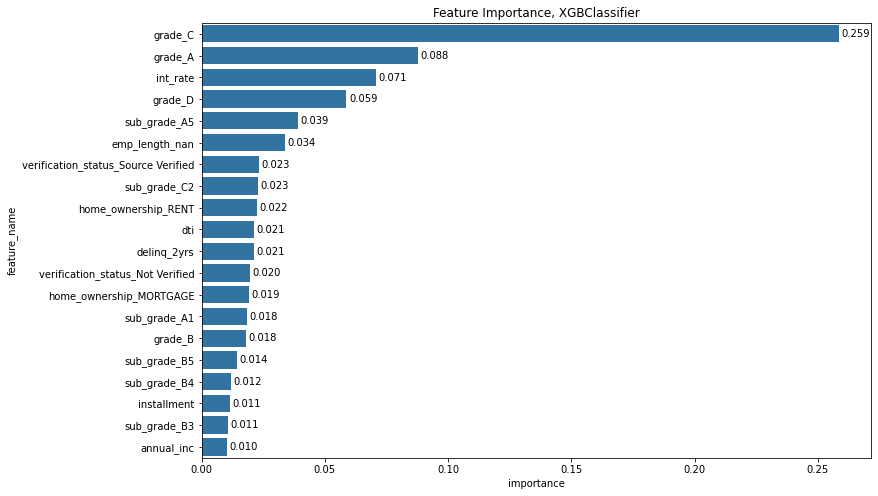

In [27]:
xgb_clf.fit(X_train_transfd, y_train)
plot_importance(xgb_clf)

## 4. Feature Engineering

#### **Feature Transformation**

C:\Users\Audimas Firian\AppData\Local\Temp\ipykernel_6548\980097948.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\anaconda3\envs\general_ds\lib\site-packages\IPython\core\pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


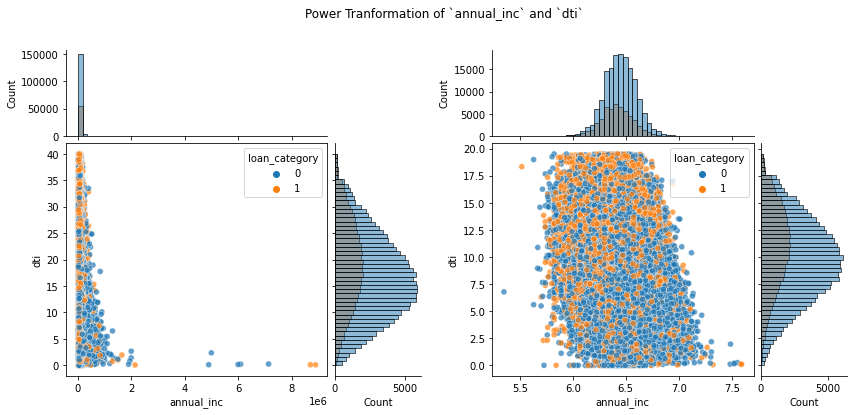

In [41]:
from sklearn.preprocessing import PowerTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable


labels = pd.DataFrame(y_train, columns=['loan_category'])
transformer_scaler = PowerTransformer(standardize=False).set_output(transform='pandas')
train_set_ = X_train[['annual_inc', 'dti']]
train_set_transfd = transformer_scaler.fit_transform(train_set_)
# merge with label
train_set_ = pd.merge(
    train_set_, labels, left_index=True, right_index=True
    )
train_set_transfd = pd.merge(
    train_set_transfd, labels, left_index=True, right_index=True
    )
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for idx, dataset in enumerate([train_set_, train_set_transfd]):
    divider = make_axes_locatable(ax[idx])
    ax_histx = divider.append_axes('top', 1.2, pad=0.1, sharex=ax[idx])
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    sns.histplot(data=dataset, x='annual_inc', ax=ax_histx, hue='loan_category', bins=50, legend=False)
    ax_histx.spines['right'].set_visible(False)
    ax_histx.spines['top'].set_visible(False)
    ax_histy = divider.append_axes('right', 1.2, pad=0.1, sharey=ax[idx])
    ax_histy.yaxis.set_tick_params(labelleft=False)
    sns.histplot(data=dataset, y='dti', ax=ax_histy, hue='loan_category', bins=50, legend=False)
    ax_histy.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    sns.scatterplot(data=dataset, x='annual_inc', y='dti', hue='loan_category', ax=ax[idx], alpha=0.7)
fig.suptitle('Power Tranformation of `annual_inc` and `dti`')
fig.show()

Plot above shows an example of power transformation using `PowerTransformer (yeo-johnson)`. See how outliers handled without explicitly removing them. However, they are still distinguishibly far from other observations.

#### **Extracting Post-Originated Features**

From previous chapter, we observed a pattern of `average portion paid` of bad loan which is associated according to its categorized loan `grade`. We will implement this extraction as below:

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

class LoanFeatureExtract(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        X = X.assign(
            portion_paid=lambda x: x.total_rec_prncp / x.loan_amnt
            )
        bad_loan_mask = np.where(y == 'Bad Loan')[0]
        map_loan_cat = {'Good Loan': 0, 'Bad Loan': 1}
        self.avg_defaulted_recovery_ = X.iloc[bad_loan_mask, :]\
            .groupby('sub_grade')\
            .aggregate(avg_defaulted_recovery=pd.NamedAgg(column='portion_paid', aggfunc='mean'))\
            .reset_index()
        self.portion_defaulted_ = \
            pd.merge(X[['sub_grade']], 
                     pd.DataFrame(y, columns=['loan_category']).apply(lambda x: x.map(map_loan_cat)), 
                     left_index=True, right_index=True)\
                .groupby('sub_grade')\
                .aggregate(avg_portion_defaulted=pd.NamedAgg(column='loan_category', aggfunc='mean'))\
                .reset_index()
        return self

    def transform(self, X, y=None):
        X = pd.merge(
            X, self.avg_defaulted_recovery_, how='left', on='sub_grade'
            )
        X = pd.merge(
            X, self.portion_defaulted_, how='left', on='sub_grade'
            )
        X = X.drop(columns=['total_rec_prncp'])
        return X

Notice that `avg_defaulted_recovery_` (and others) is served as *fitted attribute* of this transformer  . The advantage of creating this transformer is to assure that there won't be data leakage from `test set`, since the `self.avg_defaulted_recovery_` is only updated using `fit` method (refer to *scikit-learn* documentation on how this attribute won't be updated by `transform` method).

In above extraction, we try to increases the dataset knowledge regarding the `Bad Loan`.

In [43]:
dataset_preprocess = Pipeline([
    ('preprocess', LoanDataPreprocess()),
    ('extract_label_predictor', LoanDataLabelPredictor(exclude=['earliest_cr_line', 'pymnt_plan', 'policy_code'], 
                                                       include=['total_rec_prncp'])),
    ('missing_handler', LoanDataMissingHandler()),
    ])

X_train, y_train = dataset_preprocess.fit_transform(train_set)
extract_feature = LoanFeatureExtract()
extract_feature.fit_transform(X_train, y_train).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,210369,210370,210371,210372,210373,210374,210375,210376,210377,210378,210379,210380,210381,210382,210383,210384,210385,210386,210387,210388,210389,210390,210391,210392,210393,210394,210395,210396,210397,210398,210399,210400,210401,210402,210403,210404,210405
emp_length,more 10 years,more 10 years,5 years,more 10 years,2 years,4 years,more 10 years,2 years,more 10 years,more 10 years,4 years,more 10 years,5 years,9 years,less 1 year,less 1 year,8 years,2 years,more 10 years,1 year,more 10 years,5 years,2 years,more 10 years,less 1 year,3 years,7 years,more 10 years,more 10 years,5 years,more 10 years,1 year,8 years,3 years,7 years,more 10 years,more 10 years,...,1 year,3 years,more 10 years,more 10 years,NaN,3 years,4 years,more 10 years,1 year,6 years,2 years,4 years,less 1 year,5 years,5 years,less 1 year,more 10 years,more 10 years,more 10 years,more 10 years,5 years,3 years,8 years,9 years,NaN,2 years,5 years,6 years,NaN,3 years,4 years,more 10 years,more 10 years,less 1 year,2 years,more 10 years,NaN
home_ownership,RENT,RENT,MORTGAGE,MORTGAGE,MORTGAGE,RENT,RENT,MORTGAGE,RENT,MORTGAGE,OWN,MORTGAGE,RENT,OWN,RENT,MORTGAGE,RENT,RENT,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,OWN,MORTGAGE,RENT,RENT,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,RENT,RENT,RENT,MORTGAGE,MORTGAGE,OWN,...,RENT,MORTGAGE,MORTGAGE,OWN,MORTGAGE,RENT,MORTGAGE,MORTGAGE,RENT,MORTGAGE,OWN,MORTGAGE,RENT,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,MORTGAGE,OWN,MORTGAGE,OWN,MORTGAGE,MORTGAGE,RENT,MORTGAGE,RENT,MORTGAGE,MORTGAGE,OWN,RENT,RENT,MORTGAGE,MORTGAGE,RENT,RENT,MORTGAGE,OWN
annual_inc,40000.00,25000.00,325000.00,100000.00,33000.00,32760.00,98000.00,39600.00,81500.00,41000.00,70000.00,80000.00,25000.00,45000.00,175000.00,112000.00,115000.00,60000.00,67000.00,70000.00,84000.00,50000.00,55000.00,41600.00,38000.00,60000.00,90000.00,74628.00,102120.00,90000.00,60000.00,38000.00,250000.00,50000.00,87500.00,56000.00,180000.00,...,35370.00,45000.00,40160.00,80000.00,40000.00,80000.00,262000.00,84000.00,65000.00,38000.00,27000.00,55000.00,60000.00,74000.00,57200.00,252000.00,76584.00,100000.00,62000.00,55000.00,35000.00,41000.00,98000.00,42000.00,47784.00,35000.00,69000.00,75000.00,49000.00,120000.00,42000.00,63078.00,48000.00,54000.00,27000.00,50000.00,32000.00
verification_status,Source Verified,Verified,Source Verified,Verified,Not Verified,Verified,Not Verified,Source Verified,Verified,Not Verified,Verified,Source Verified,Source Verified,Not Verified,Verified,Not Verified,Not Verified,Verified,Source Verified,Not Verified,Source Verified,Verified,Not Verified,Source Verified,Not Verified,Not Verified,Source Verified,Verified,Not Verified,Not Verified,Source Verified,Not Verified,Verified,Not Verified,Not Verified,Verified,Not Verified,...,Verified,Not Verified,Source Verified,Verified,Source Verified,Not Verified,Not Verified,Verified,Source Verified,Not Verified,Source Verified,Verified,Source Verified,Not Verified,Verified,Source Verified,Verified,Source Verified,Source Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Verified,Source Verified,Verified,Not Verified,Source Verified,Verified,Verified
dti,16.94,24.68,18.55,22.18,15.75,27.06,6.15,2.49,16.73,25.79,19.20,16.70,27.03,8.91,8.07,7.39,7.37,13.56,17.61,25.14,19.80,10.83,18.84,28.25,20.02,3.68,9.56,25.92,15.85,14.76,19.62,21.54,5.98,17.95,9.82,21.45,8.04,...,15.95,31.44,31.53,23.65,20.70,9.82,9.51,16.54,8.49,9.03,18.62,26.58,10.10,22.25,28.85,9.86,12.83,23.74,10.88,31.22,18.93,26.70,15.56,26.74,14.69,8.30,8.23,23.35,22.58,26.60,10.66,31.70,36.93,13.22,18.58,12.63,29.44
delinq_2yrs,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,2.00,0.00,0.00,0.00,...,0.00,4.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,2.00

We can confirm that there is no **post-originated loan data** in our transformer. Using this process, we can infer the future trends (based on our knowledge in available data) without leaking unknown data, mimics the real condition of future prediction.

#### **Combining into Pipeline**

Let's recap our model pipeline up to this section:

In [44]:
scale_cols = [
    'mths_since_last_delinq',
    'mths_since_last_record',
    'mths_since_last_major_derog',
    'mths_since_rcnt_il',
    'inq_last_6mths',
    'collections_12_mths_ex_med', 
    'acc_now_delinq', 'open_acc_6m', 
    'open_il_12m', 'open_il_24m',
    'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
    'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
    'max_bal_bc', 
    ]
categorical_cols = [
    'emp_length', 'home_ownership', 
    'verification_status', 'grade', 'sub_grade']
transform_cols = [
    'annual_inc', 'dti', 'delinq_2yrs', 
    'open_acc',
    'revol_bal', 'revol_util', 'total_acc',
    'tot_coll_amt', 'tot_cur_bal',
    'total_rev_hi_lim',  'pub_rec', 'int_rate',
    'installment', 'loan_amnt']
dataset_preprocess = Pipeline([
    ('preprocess', LoanDataPreprocess()),
    ('extract_label_predictor', LoanDataLabelPredictor(exclude=['earliest_cr_line', 'pymnt_plan', 'policy_code', 'term'], 
                                                       include=['total_rec_prncp'])),
    ('missing_handler', LoanDataMissingHandler()),
    ])
feature_modifier = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('power', PowerTransformer(standardize=False), transform_cols),
    # ('discretize', RobustScaler(), scale_cols)
    ], remainder='passthrough').set_output(transform='pandas')
dataset_pipeline = Pipeline([
    ('feature_extract', LoanFeatureExtract()),
    ('feature_modifier', feature_modifier)
])

dataset_pipeline


Pipeline(steps=[('feature_extract', LoanFeatureExtract()),
                ('feature_modifier',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['emp_length',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'grade', 'sub_grade']),
                                                 ('power',
                                                  PowerTransformer(standardize=False),
                                                  ['annual_inc', 'dti',
                                                   'delinq_2yrs', 'open_acc',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'tot_coll_amt',
                                                   'tot_cur_bal',
                                                   'total_rev_hi_lim',
                                                   'pub_rec', 'int_rate',
                                                   'installment',
                                                   'loan_amnt'])]))])

Now let's try our XGBoost model for any performance improvement.

In [45]:
# prepare the dataset
X_train, y_train = dataset_preprocess.fit_transform(train_set)
X_test, y_test = dataset_preprocess.transform(test_set)
X_train_transfd = dataset_pipeline.fit_transform(X_train, y_train)
X_test_transfd = dataset_pipeline.transform(X_test)
y_train = np.vectorize(map_array)(y_train)
y_test = np.vectorize(map_array)(y_test)
# prepare model
xgb_clf = XGBClassifier(
    max_depth=4, alpha=10, learning_rate=0.5, n_estimators=100,
    )
# initialize an empty list to store the scores
scoring_method = make_scorer(roc_auc_score, needs_proba=True) # returns callable in form of scorer(estimator, X, y)
# cross_val_evaluation([xgb_clf], X_train_transfd, y_train, scoring_method)

Let's check feature importance and identify if any of our extracted feature is importance.

Text(0.5, 1.0, 'Feature Importance, XGBoostClassifier')

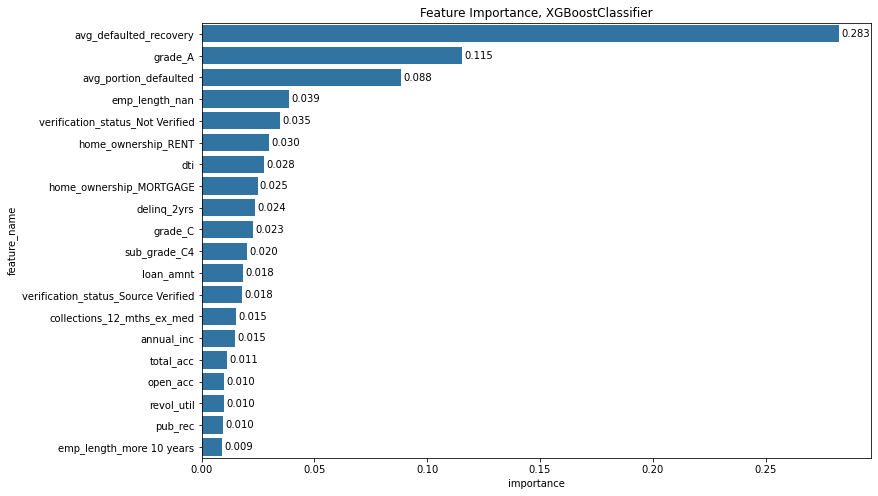

In [ ]:
xgb_clf.fit(X_train_transfd, y_train)
plot_importance(xgb_clf)

It may be possible to perform a regression problem of `total_loan_recovery` and serve the regression results as a new predictor. This kind of imputation is expensive therefore not implemented in this analysis.

## 4. Hyperparameter Optimization

Let's first inspect how our boosting performs at each step to get a general idea of hyperparameter optimization strategy!

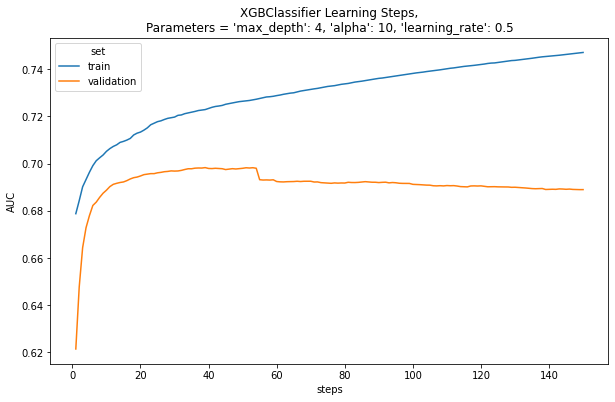

In [70]:
def plot_xgb_learning_step(
        X_train, y_train, X_test, y_test, 
        num_rounds=100, params={}):
    # boost element
    boost = None
    # classifier
    xgb = XGBClassifier(n_estimators=1, **params)
    # iteration records
    boost_step_no = []
    auc_train = []
    auc_val = []
    # iterate for each step
    def boost_step(steps):
        nonlocal xgb, boost, boost_step_no, auc_train, auc_val, X_train, y_train, X_test, y_test
        if steps == 0:
            boost = xgb.fit(X_train, y_train) # first step must be fitted
        else:
            boost = xgb.fit(X_train, y_train, xgb_model=boost) # use fitted boost step
        y_train_proba = boost.predict_proba(X_train)[:, 1]
        y_test_proba = boost.predict_proba(X_test)[:, 1]
        auc_train.append(roc_auc_score(y_train, y_train_proba))
        auc_val.append(roc_auc_score(y_test, y_test_proba)) 
        boost_step_no.append(i + 1)   
    for i in range(num_rounds):
        boost_step(i)
    #plot
    plot_df = pd.DataFrame(np.c_[boost_step_no, auc_train, auc_val], columns=['steps', 'train', 'validation'])
    plot_df = pd.melt(
        plot_df, id_vars=['steps'], value_vars=['train', 'validation'],
        var_name='set', value_name='AUC')
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=plot_df, x='steps', y='AUC', hue='set', ax=ax)
    ax.set_title(f'{boost.__class__.__name__} Learning Steps,\nParameters = {str(params).strip("{}")}')
    
model_params = {
    'max_depth': 4, 
    'alpha': 10, 
    'learning_rate': 0.5,
    }
plot_xgb_learning_step(
    X_train_transfd, y_train, X_test_transfd, y_test, 
    num_rounds=150, params=model_params)

We can see the point that our model start overfitting the train set. We will implement `Early Stopping Callbacks` to get the where is the best round numbers of learning.

In [75]:
xgb_clf = XGBClassifier(
    max_depth=4, alpha=10, learning_rate=0.5, n_estimators=100,
    early_stopping_rounds=10, eval_metric='auc', 
    )
xgb_clf.fit(
    X_train_transfd, y_train,
    eval_set=[(X_test_transfd, y_test)], verbose=False)
print(f'XGBoostClassifier best scores (AUC, validation set): {xgb_clf.best_score:.3f} at {xgb_clf.best_iteration} iterations')

XGBoostClassifier best scores (AUC, validation set): 0.698 at 38 iterations


Unfortunately, after early stopping the final fitted iterations is the last iteration performed (not the best one). This should be noted so that our final model should be fitted using best iteration numbers.

#### **Pipeline for Hyperparameter Optimization**

Here I determine the hyperparameters to be optimized using `Neuraxle AutoML Pipeline`:

In [68]:
from neuraxle.pipeline import Pipeline
from neuraxle.hyperparams.distributions import Boolean, Choice, LogUniform
from neuraxle.hyperparams.space import HyperparameterSpace
# Scikit-learn wrapper
from neuraxle.steps.sklearn import SKLearnWrapper


ModuleNotFoundError: No module named 'neuraxle'

## 3. Baseline Models

Now we are going to select several potentially baseline model for our classification task!
For each potential model, we are going to observe how the model performs by comparing the model performance. And also, we will perform *Feature Selection* using `Recursive Feature Elimination (RFE)`, focusing on `accuracy` score of `Charged Off` class. 

### 2.1. Stochastic Gradient Descent Classifier (SGDClassifier)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=99)


#### **Feature Selection**

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

features_evaluator = RFECV(estimator=sgd_clf, cv=StratifiedKFold(2), scoring='recall')
features_evaluator.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
rfecv_mean = features_evaluator.cv_results_['mean_test_score']
optimal_n_features = features_evaluator.n_features_

# plotting
def plot_feature_evaluator(rfecv_mean, optimal_n_features):
    plt.plot(
        range(1, len(rfecv_mean) + 1), rfecv_mean
    )
    plt.xlabel('Number of features selected')
    plt.ylabel('Cross validation score')
    print(f'Optimal number of features: {optimal_n_features}')

plot_feature_evaluator(rfecv_mean, optimal_n_features)

In [ ]:
features_selector = RFECV(
    estimator=sgd_clf, cv=StratifiedKFold(2), scoring='recall',
    min_features_to_select=optimal_n_features)

In [ ]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline, Pipeline

sgd_clf_model = Pipeline([
    ('features_selector', features_selector),
    ('sgd_classifier', SGDClassifier(random_state=99))
])

#### **Performance Measure**

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# decision function to plot precision-recall curve
y_train_pred = \
    cross_val_predict(
        sgd_clf_model, X_train_res_transf, 
        y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), cv=3)
confusion_matrix(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_train_pred)

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=thresholds, y=precisions[:-1], ax=ax, label='Precision')
    sns.lineplot(x=thresholds, y=recalls[:-1], ax = ax, label='Recall')
    ax.lines[0].set_linestyle('--')
    ax.lines[1].set_linestyle('-')
    plt.xlabel('Treshold')
    plt.legend()
    plt.show()
    # plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    # plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

y_scores_sgd = \
    cross_val_predict(
        sgd_clf_model, X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), cv=3,
        method='decision_function')
precisions, recalls, thresholds = \
    precision_recall_curve(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_scores_sgd)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
def plot_precision_recalls(precisions, recalls):
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x=precisions, y=recalls, ax=ax)
    plt.xlabel('Precisions')
    plt.ylabel('Recalls')
    
plot_precision_recalls(precisions, recalls)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_scores_sgd)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (recall)')

plot_roc_curve(fpr, tpr)
    

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}), y_scores_sgd)

print(f'AUC Score= {auc:.2f}')

In [ ]:
from imblearn.metrics import classification_report_imbalanced

sgd_clf_model.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
y_pred_test = sgd_clf_model.predict(X_test_transf)

print(classification_report_imbalanced(y_test.map({'Fully Paid': 0, 'Charged Off': 1}), y_pred_test))

### 2.2. XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(verbosity=0, use_label_encoder=False)
xgb_clf.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
y_pred_test = xgb_clf.predict(X_test_transf)

print(classification_report_imbalanced(y_test.map({'Fully Paid': 0, 'Charged Off': 1}), y_pred_test))


In [ ]:
features_evaluator = RFECV(estimator=xgb_clf, cv=StratifiedKFold(2), scoring='recall')
features_evaluator.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
rfecv_mean = features_evaluator.cv_results_['mean_test_score']
optimal_n_features = features_evaluator.n_features_

plot_feature_evaluator(rfecv_mean, optimal_n_features) 

In [ ]:
features_selector = RFECV(
    estimator=xgb_clf, cv=StratifiedKFold(2), scoring='recall',
    min_features_to_select=optimal_n_features)

xgb_clf_model = Pipeline([
    ('features_selector', features_selector),
    ('xgb_classifier', XGBClassifier(verbosity=0))
])

xgb_clf_model.fit(X_train_res_transf, y_train_res.map({'Fully Paid': 0, 'Charged Off': 1}))
y_pred_test = xgb_clf.predict(X_test_transf)

print(classification_report_imbalanced(y_test.map({'Fully Paid': 0, 'Charged Off': 1}), y_pred_test))

#### **Neural Network Model**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

# creating model function, specify parameters to be cv-ed later
def mlp_model( 
        n_hidden, n_neurons, activation, 
        meta: dict, compile_kwargs: dict):
    input_ = keras.layers.Input(shape=(meta['n_features_in_']))
    dense = keras.layers.Dense(n_neurons, activation=activation)(input_)
    for layer in range(n_hidden - 1):
        dense = keras.layers.Dense(n_neurons, activation=activation)(dense)
    output_ = keras.layers.Dense(1, activation='sigmoid')(dense)
    model = keras.Model(inputs=[input_], outputs=[output_])
    # compiling model
    model.compile(
        loss='binary_crossentropy', 
        optimizer=compile_kwargs['optimizer'])
    return model

mlp_binary_clf = KerasClassifier(
    model = mlp_model,
    n_hidden = 5,
    n_neurons = 20,
    activation='relu',
    optimizer = 'adam',
    optimizer__learning_rate=0.001,
    epochs=100,
    verbose=0,
)